In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data[data["total sulfur dioxide"] < 200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

quality_threshold = 5
data["boolQuality"] = 0
tmp = data["quality"] > quality_threshold
tmp = tmp.astype(int)
data["boolQuality"] = tmp

In [10]:
data_tensor = torch.tensor(data[cols2zscore].values).float()
labels_tensor = torch.tensor(data["boolQuality"].values).float()
labels_tensor = labels_tensor[:, None]

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [12]:
class ANNWine(nn.Module):
    def __init__(self, activation_func):
        super().__init__()

        self.input = nn.Linear(11, 16)

        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        self.output = nn.Linear(32, 1)

        self.activation_func = activation_func

    def forward(self, x):
        func = getattr(torch.nn, self.activation_func)
        activation_func = func()
        x = activation_func(self.input(x))
        x = activation_func(self.fc1(x))
        x = activation_func(self.fc2(x))

        return self.output(x)

In [13]:
epochs = 1000


def train_model():
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)

    train_acc = []
    test_acc = []

    for i in range(epochs):
        model.train()

        batch_acc = []

        for X, y in train_loader:
            preds = model(X)
            loss = loss_func(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100 * torch.mean(((preds > 0) == y).float()).item())

        train_acc.append(np.mean(batch_acc))

        model.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            preds = model(X)
        test_acc.append(100 * torch.mean(((preds > 0) == y).float()).item())

    return train_acc, test_acc

In [14]:
activation_functions = ["ReLU", "ReLU6", "LeakyReLU"]

trainByAct = np.zeros((epochs, len(activation_functions)))
testByAct = np.zeros((epochs, len(activation_functions)))

for i, function in enumerate(activation_functions):
    model = ANNWine(function)
    trainByAct[:, i], testByAct[:, i] = train_model()

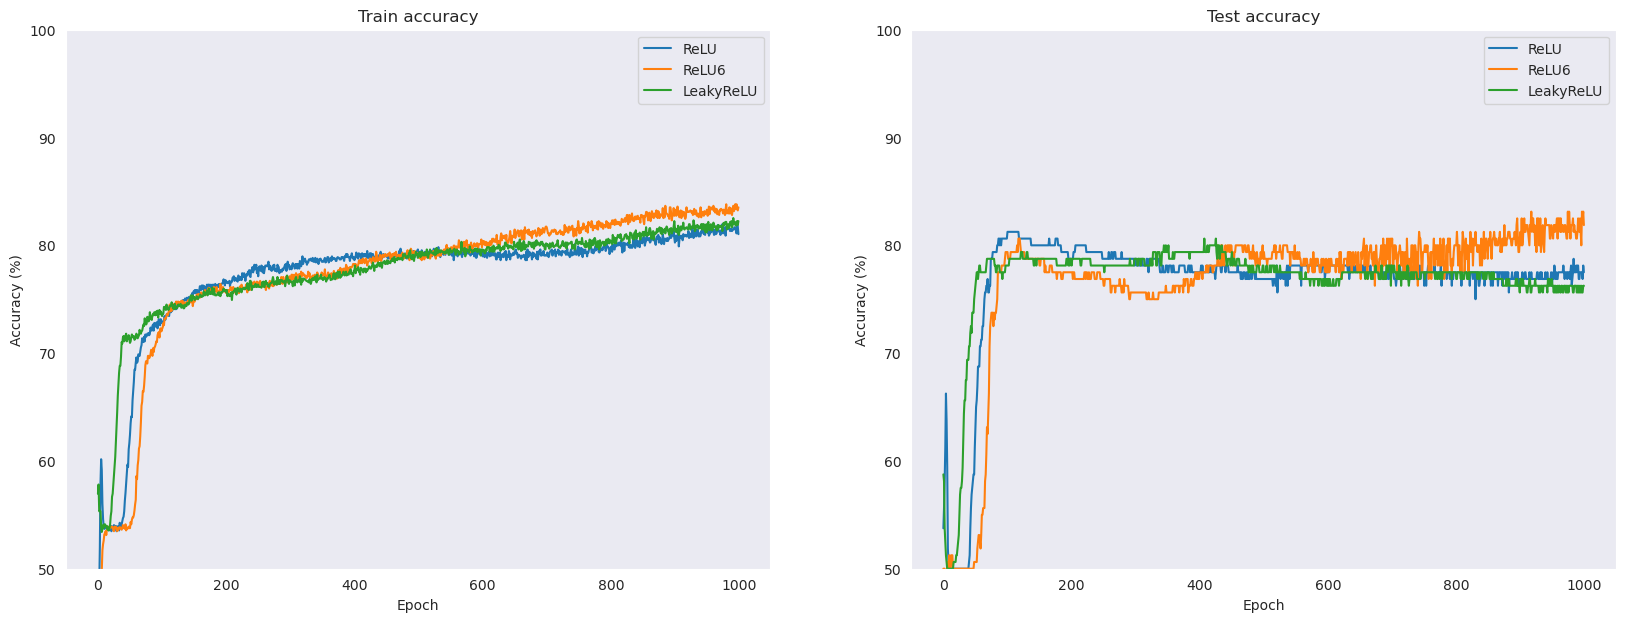

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(trainByAct)
ax[0].set_title("Train accuracy")
ax[1].plot(testByAct)
ax[1].set_title("Test accuracy")

for i in range(2):
    ax[i].legend(activation_functions)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 100])
    ax[i].grid()

plt.show()